### Simple clustering example using the package

In [1]:
import numpy as np
from matplotlib import pyplot as plt

Importing the package main class, and the Normal Inverse Wishart (NIW) prior.

Follow the installation guide at: https://github.com/BGU-CS-VIL/DPMMPython before importing. Extra steps are required after `pip install`.

In [2]:
from julia.api import Julia
jl = Julia(compiled_modules=False)

from dpmmpython.dpmmwrapper import DPMMPython
from dpmmpython.priors import niw

[ Info: Julia version info


Julia Version 1.7.3
Commit 742b9abb4d (2022-05-06 12:58 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
      Ubuntu 20.04.4 LTS
  uname: Linux 5.15.0-41-generic #44~20.04.1-Ubuntu SMP Fri Jun 24 13:27:29 UTC 2022 x86_64 x86_64
  CPU: Intel(R) Core(TM) i7-8565U CPU @ 1.80GHz: 
              speed         user         nice          sys         idle          irq
       #1  2000 MHz       4557 s        177 s        964 s      53755 s          0 s
       #2  2000 MHz       4406 s        142 s        987 s      53928 s          0 s
       #3  2000 MHz       3702 s         88 s        987 s      54572 s          0 s
       #4  2000 MHz       4540 s         72 s        983 s      53874 s          0 s
       #5  2000 MHz       3757 s        247 s        950 s      54456 s          0 s
       #6  2000 MHz       4260 s         79 s       1096 s      53039 s          0 s
       #7  4029 MHz       4308 s        251 s       1008 s      53908 s          0 s
       #8  2000 MHz       4470 s    

[ Info: Julia executable: /home/dinari/Downloads/julia-1.7.3-linux-x86_64/julia-1.7.3/bin/julia
[ Info: Trying to import PyCall...
┌ Info: PyCall is already installed and compatible with Python executable.
│ 
│ PyCall:
│     python: /usr/bin/python3
│     libpython: /usr/lib/x86_64-linux-gnu/libpython3.8.so.1.0
│ Python:
│     python: /usr/bin/python3
└     libpython: 


### Data Generation

We will use the package data generation function to generate some 2D data

In [3]:
D = 2 # Dimension
K = 20 # Number of Clusters
N = 20000 #Number of points
var_scale = 100.0 # The variance of the MV-Normal distribution where the clusters means are sampled from.
data, labels = DPMMPython.generate_gaussian_data(N, D, K, var_scale)

[228, 1962, 951, 214, 1096, 181, 867, 245, 179, 90, 98, 665, 217, 1997, 151, 647, 178, 1171, 5258, 3605]


Plotting the data

Note that as Julia is a column first language, the data generated is $DxN$

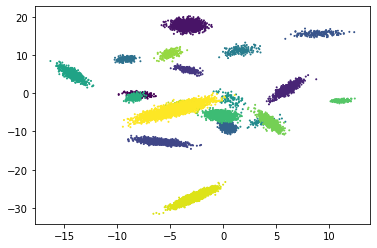

In [6]:
plt.scatter(data[0,:],data[1,:],c=labels, s=1)

### Fiting DPGMM Model to the data

Start by defining a niw prior and $\alpha$

In [7]:
prior = niw(1,np.zeros(D),2,np.eye(D)*0.5)
alpha = 10.0

Fit the model and store the results in `results`.
When working from Jupyter Notebook/Lab you will not see Julia prints. However when running python from terminal you will see all the prints (as in the Julia packages)

In [15]:
results = DPMMPython.fit(data,alpha,prior = prior,iterations=50, burnout=5,smart_splits=False)

The returned object is a tuple with  `(labels, cluster_distribution,sub_labels)`, we will only require the first item

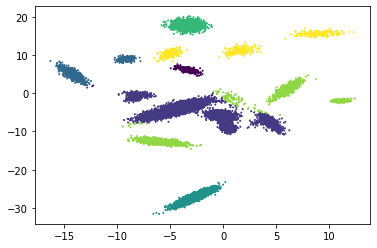

In [16]:
inferred_labels = results[0]
plt.scatter(data[0,:],data[1,:],c=inferred_labels, s=1)

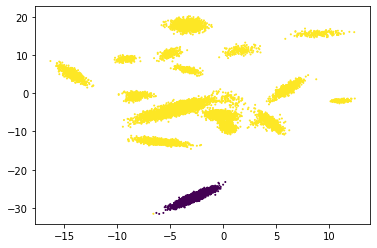

Looks good, we can quantilize the quality of the clustering using NMI:

In [10]:
from sklearn.metrics.cluster import normalized_mutual_info_score

In [11]:
dpgmmm_nmi = normalized_mutual_info_score(inferred_labels.astype(int), np.array(labels),average_method='arithmetic')
print(f'DPGMM NMI:{dpgmmm_nmi}')                                          

DPGMM NMI:0.9728852990709327


### Comparing VS other methods

In [12]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

#### K-means:

In [13]:
kmeans = KMeans(n_clusters=K).fit(data.T)
kmeans_labels = kmeans.labels_

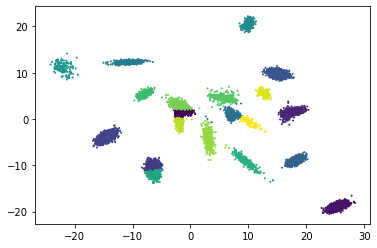

In [14]:
plt.scatter(data[0,:],data[1,:],c=kmeans_labels, s=1)

In [15]:
kmeans_nmi = normalized_mutual_info_score(kmeans_labels.astype(int), np.array(labels),average_method='arithmetic')
print(f'K-means NMI:{kmeans_nmi}')      

K-means NMI:0.9309229767796119


#### GMM:

In [16]:
gmm = GaussianMixture(n_components=20,covariance_type='full').fit(data.T)
gmm_labels = gmm.predict(data.T)

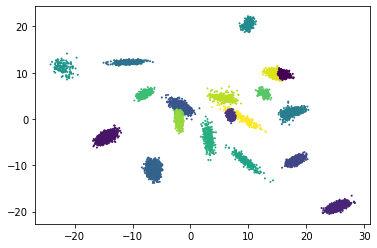

In [17]:
plt.scatter(data[0,:],data[1,:],c=gmm_labels, s=1)

In [18]:
gmm_nmi = normalized_mutual_info_score(gmm_labels.astype(int), np.array(labels),average_method='arithmetic')
print(f'GMM NMI:{gmm_nmi}')  

GMM NMI:0.9513343588873828


Even when using the correct K for K-means and GMM, the DPGMM outperform them.